# LAX, What do you want to know?


This project is originally from my curiosity. While travelling to LAX, these questions came to my mind.

- Where do the flights landed in LAX depart from? How many flights?
- Predict delay?
- What is the busiest time?

I was trying to search them up, but, unfortunately, Google didn't satisfy my curioisty. (You can try!). Well, let answer them by myself then!!


### What to expect?

- Fun! Fulfil your curiosity

### What not to expect?

- Cutting-edge technology or novel approach, nah, not at all. Just simple tools that everyone knows.
- Price Analysis. Go to Expedia if you want!




In [1]:
from scrape import daily, sort_flight_by_time
import json
import pandas as pd
import requests

## Where to get data?

First of all, there are many websites that provide realtime fligts information in LAX. I decided to use [this]( https://www.airport-la.com/lax/arrivals). As you can see, its structure is very simple, mostly HTML. Easy to scrape, huh?


* Run the script manually
* Host it somewhere
    * https://www.pythonanywhere.com/ (free)
    * AWS Free Tier

In [2]:
# daily()

with open("database.json", "r") as f:
    db = json.load(f)


Then what next? The table from [Airport-LA website](https://www.airport-la.com/lax/arrivals) has IATA code, which is .... Maybe we need something that make more sense for normal people, like where exacyly they are? Also [Airport-LA website](https://www.airport-la.com/lax/arrivals)  tells you the city where flights are from but not country. Do you know where on earth is Puerto Vallarta?? I don't know and I don't want wasting time search it up everytime. Let's make some tools to visualize!!


1. IATA Airport Code from  https://datahub.io/core/airport-codes
2. Country Code from https://datahub.io/core/country-list


In [3]:
airport_locations_response = requests.get("https://datahub.io/core/airport-codes/r/airport-codes.json")
if airport_locations_response.status_code == 200:
    airport_locations = {e["iata_code"]: {
        "display_name": e["name"],
        "lat": e["coordinates"].split(",")[0],
        "lon": e["coordinates"].split(",")[1],
        "country": e["iso_country"]
    } for e in airport_locations_response.json() if e["iata_code"] is not None}
else:
    print("unable to download IATA Data")

country_code_response = requests.get("https://datahub.io/core/country-list/r/data.json")
if country_code_response.status_code == 200:
    country_code = {e["Code"]: e["Name"] for e in country_code_response.json()}
else:
    print("unable to download Country Data")


In [4]:
df = sort_flight_by_time(db, airport_locations, country_code)

Let's see what is our data looks like!

In [5]:
df.head()

,dt_scheduled,dt_actual,flight,gate,airport,city,country,lat,long,display name,status
0,2020-02-19 07:10:00,2020-02-20 06:53:00,TN2,TBIT,PPT,Papeete,French Polynesia,-149.606995,-17.553699,Faa'a International Airport,Landed
1,2020-02-19 07:14:00,2020-02-19 07:13:00,DL1240,2 25,SAN,San Diego,United States,-117.190002441,32.7336006165,San Diego International Airport,Landed
2,2020-02-19 07:15:00,2020-02-20 06:49:00,WN1270,1 11A,RNO,Reno,United States,-119.76799774169922,39.49909973144531,Reno Tahoe International Airport,Landed
3,2020-02-19 07:18:00,2020-02-19 07:12:00,AA1356,4 40,LAS,Las Vegas,United States,-115.1520004,36.08010101,McCarran International Airport,Landed
4,2020-02-19 07:18:00,2020-02-20 06:50:00,OO5626,7 75A,SBP,San Luis Obispo,United States,-120.641998291,35.236801147499996,San Luis County Regional Airport,Landed


### What is the busiest time?

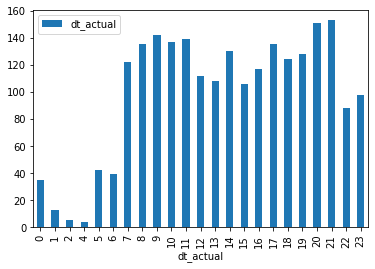

In [6]:
df[["dt_actual"]].groupby(df["dt_actual"].dt.hour).count().plot(kind="bar")

### What City?

In [7]:
df[["flight", "city", "country"]].groupby(["country", "city"]).count().sort_values(["flight"], ascending=False).head(20)

flight
country       city                  
United States San Francisco      146
              New York           118
              Las Vegas          111
              Seattle             85
              Chicago             82
              Denver              65
              San Jose            61
              Dallas              60
              Phoenix             59
              Houston             57
              Honolulu            51
              Portland            49
              Atlanta             49
              Salt Lake City      44
              Newark              44
              Oakland             43
              Boston              41
              Washington          41
              Austin              40
              Sacramento          32

In [8]:
df[["flight",  "country"]].groupby(["country"]).count().sort_values(["flight"], ascending=False).head()

,flight
country,
United States,1913
Mexico,77
Canada,61
Japan,23
United Kingdom,23


# what flight fly daily?

In [9]:
df[["flight", "airport", "city"]].groupby(["flight", "airport"]).count()

,,city
flight,airport,
5D2704,MTY,3
AA1,JFK,3
AA1029,ORD,3
AA1061,MIA,4
AA1085,DFW,3
...,...,...
WS1510,YYC,3
WS1512,YYC,3
WS1696,YVR,3


In [10]:
df[df["flight"] == "AA1061"]

,dt_scheduled,dt_actual,flight,gate,airport,city,country,lat,long,display name,status
631,2020-02-20 00:28:00,2020-02-20 00:23:00,AA1061,4 48A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Landed
933,2020-02-21 00:28:00,2020-02-21 00:28:00,AA1061,4 48A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Scheduled
1475,2020-02-22 00:28:00,2020-02-22 00:28:00,AA1061,4 48A,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Scheduled
2178,2020-02-23 00:28:00,2020-02-23 00:28:00,AA1061,4 43,MIA,Miami,United States,-80.29060363769531,25.79319953918457,Miami International Airport,Scheduled
